## Imports

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} ggplot
# !sed -i "s,from pandas.lib import Timestamp,from pandas import Timestamp,g" /opt/conda/lib/python3.6/site-packages/ggplot/stats/smoothers.py
# !sed -i "s,smoothed_data.sort('x'),smoothed_data.sort_values('x'),g" /opt/conda/lib/python3.6/site-packages/ggplot/stats/stat_smooth.py
# !sed -i "s,sort(fillcol_raw),sort_values(fillcol_raw),g" /opt/conda/lib/python3.6/site-packages/ggplot/ggplot.py

In [2]:
from __future__ import division # backward compatibility for python2
import numpy as np
import pandas as pd
import scipy.special
import operator
import random
#library for plotting arrays

import matplotlib.pyplot as plt

from ggplot import *

# Import timer for Benchmarking time
import time

import math

# Import SKlearn packages that allow us to scale `Normalise` our data.
from sklearn.preprocessing import StandardScaler

# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [3]:
seed = 256712
np.random.seed(seed)

## Set Our Global Variables
Later you will need to modify these to present your solution to the Exercise

In [4]:
# datasets to read
# you can change these when trying out other datasets
# data_file = "Iris.csv"
data_file = "data/sonar.csv"


### Read the Dataset using a Pandas Data Frame Object

Lets create a function to read the data file and split it into test and train 
based on the ratio specified by split. For instance when split = 0.5 then train and test will 
contain a similar number of instances. 
Typically we would use a 70:30 or 80:20 split (i.e. 0.7 or 0.8)

In [5]:
def load_dataset(filename, split=0.8, fraction = 1.0):
    dataframe = pd.read_csv(filename)
    
    dataframe = dataframe.sample(frac=fraction, replace=True)
    
    
    #Rearange to make first column the last
    
#     print("Before")
#     print(dataframe.head())
    
#     cols = dataframe.columns.tolist()
#     cols = cols[-(len(cols)-1):] + cols[:-(len(cols)-1)]
    
#     dataframe = dataframe[cols]
    
#     print("After")
#     print(dataframe.head())
    
    
    
    #Overide to Class_index to always be the Last Column
    class_idx = len(dataframe.columns)-1
    
    
    #dataframe = dataframe.sample(len(dataframe))
    instances = dataframe.values


    print ("Class Index: "+str(class_idx))
    # dpockemivide data into label and feature sets.
    X = instances[:,0:class_idx] # you may need to change these depending on which dataset you are use
    Y = instances[:,class_idx] 
    
#     print("X",X,":","Y",Y)
    
   
    X_train = [] # features for the train set
    Y_train = [] # class labels for the train set
    X_test = [] # features for the test set
    Y_test = [] # class labels for the test set
    
    # the zip iterator is a neat construct in Python
    # it lets you iterate over 2 arrays / lists structures 
    # importantly it iterates upto the length of the smallest structure of the two 
    # in our case X and Y will be of same length
    for  x, y in zip(X, Y): 
        if random.random() < split: # Return the next random floating point number in the range [0.0, 1.0) and compare
            X_train.append(x)
            Y_train.append(y)
        else:
            X_test.append(x)
            Y_test.append(y)       
    print("train set size: ", len(X_train))       
    print("test set size: ", len(X_test))
    
    return X_train, Y_train, X_test, Y_test

## Define Similarity Metrics
In this section we define alternative similarity metrics.
We have provided the Manhatten and Euclidean that was discussed in the class.
You can also see that we can use the basic dot product as a sim metric. However results tend to be poor because a dot product is only concerned about the overlap between two lists and less conernced about the differences. 

In [6]:
#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        print("here")
        return np.dot(instance1, instance2)

# Exercise
How might you implement a new similarity metric such as cosine?


## Define Evaluation Metrics
We will use the accuracy on test set as a measure of kNN's performance.

In [7]:
    #Finally, we can test to see how many of the test instances we got correct
    def accuracy(results):
        correct = 0
        for predict, target in results:
            
            if predict == target:
                correct += 1
        return (correct/float(len(results))) * 100.0

## Build our k-NN Class
Some of the key methods include:

init : initialisation method to set all the class variables

get_neighbours : get the nearest neighbours using the specified similarity function

predict: get the prediction either using weighted or unweighted voting

test: return results of applying kNN to each instances in a test set

In [8]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        for x in range(self.k): #extract the k top indices of the collection for return
            neighbours.append(similarities[x])

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

## Load the Data Set

In [9]:
#Load the dataset and maintain the features (X) and class labels (Y) separately  
# make sure you understand what the 4 and 0.8 default values are in the call
# you may have to modify these depending on the dataset you work with.
X_train, Y_train, X_test, Y_test = load_dataset(data_file, split=0.8, fraction=1.0)

Class Index: 60
train set size:  175
test set size:  33


## Apply kNN to Test Data
Here we can try out both versions of the kNN i.e. weighted and unweighted
and compare their results. This differences becomes obvious mostly in 
situations when ties are frequently encountered in voting. 

Notice how we use the accuracy function to compute performance on test data.

In [10]:
#create an instance of kNN 
# pass the training instances with their class labels (i.e. X_train and Y_train)
# we will use the default kNN class settings for parameters i.e. k=3, sim=manhattan, weighted=False

print("Deduce a Good K-Value: ", math.sqrt(len(Y_test)))

knn = kNN(X_train, Y_train, k=int(math.sqrt(len(Y_test))))

knn.test(X_test, Y_test) # now get the predictions on the test set

print("kNN Accuracy on test set is: ", accuracy(knn.results))


Deduce a Good K-Value:  5.744562646538029
kNN Accuracy on test set is:  87.87878787878788


## Exercise 
Apply kNN to test data and to explore:
- impact of different train-test splits in "Load the data set"
- impact of different k values
- impact of different similarity metrics

Is the accuracy better, worse or similar?


## How to Setup an Experiment with Multiple Values of k?
Often we want to explore the impact of increasing values of k on kNN performace.
Given the class descriptions above we can set this up as shown below.
Lets load the dataset using a new split.

In [11]:
#Load the dataset and maintain the features (X) and class labels (Y) separately  
# make sure you understand what the 4 and 0.8 default values are in the call
X_train, Y_train, X_test, Y_test = load_dataset(data_file, split=0.8, fraction=1.0)

Class Index: 60
train set size:  157
test set size:  51


In [12]:
print("Setup the kNN instances ...")
euc_knn_list = []

euc_time_list = []

ks = []

# ks = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 75, 100] # try a few different values for k

for k_val in range(1, 100):
    ks.append(k_val)

is_weighted = [False, True] # try two different forms of voting

# iterate over different voting strategies
for weighted in is_weighted:
    euc_knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for k in ks:
        #create the different instances of the kNN class
        
        knn = kNN(X_train, Y_train, k, euclidean, weighted)
        
        euc_knn_list_element.append(knn)
        
        pass
    
    euc_compiled_row = {}
    
    euc_knn_list.append(euc_knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
euc_knn_results = []
euc_knn_result_element = []

for knn1 in euc_knn_list:
    euc_knn_result_element = []

    for knn2 in knn1:
        knn2.test(X_test, Y_test)
             
        euc_knn_result_element.append(accuracy(knn2.results))
        
        pass
    pass
    euc_knn_results.append(euc_knn_result_element)
    pass


Setup the kNN instances ...


In [13]:
# print("Results from trials...", euc_knn_results)

In [14]:
euc_compiled_results = []
for weight_index in range(0, len(euc_knn_results)):
    for accuracy_index in range(0, len(euc_knn_results[weight_index])):
        euc_compiled_row = {}
        euc_compiled_row['K'] = ks[accuracy_index]
        if weight_index:
            euc_compiled_row['Weighted'] = True
        else:
            euc_compiled_row['Weighted'] = False
        euc_compiled_row['Accuracy'] = euc_knn_results[weight_index][accuracy_index]
        euc_compiled_results.append(euc_compiled_row)

euc_K_on_accuracy_df = pd.DataFrame(euc_compiled_results)
euc_K_on_accuracy_df

,Accuracy,K,Weighted
0,86.274510,1,False
1,82.352941,2,False
2,80.392157,3,False
3,76.470588,4,False
4,72.549020,5,False
5,78.431373,6,False
6,80.392157,7,False
7,76.470588,8,False
8,60.784314,9,False
9,58.823529,10,False


## Lets Plot Our Results on a Bar Chart

In [15]:
# N = len(ks) # this is the number of results we want to plot pn the x-axis
# ind = np.arange(N) 

# performance1 = euc_knn_results[0]
# performance2 = euc_knn_results[1]

# width = 0.35 # width of the bar      
# plt.bar(ind, performance1, width, label='Unweighted')
# plt.bar(ind + width, performance2, width, label='Weighted')

# plt.ylabel('Accuracy')
# plt.xlabel('k')
# plt.title('kNN performance with increasing')

# plt.xticks(ind + width / 2, ks)
# plt.legend(loc='lower right')
# plt.show()

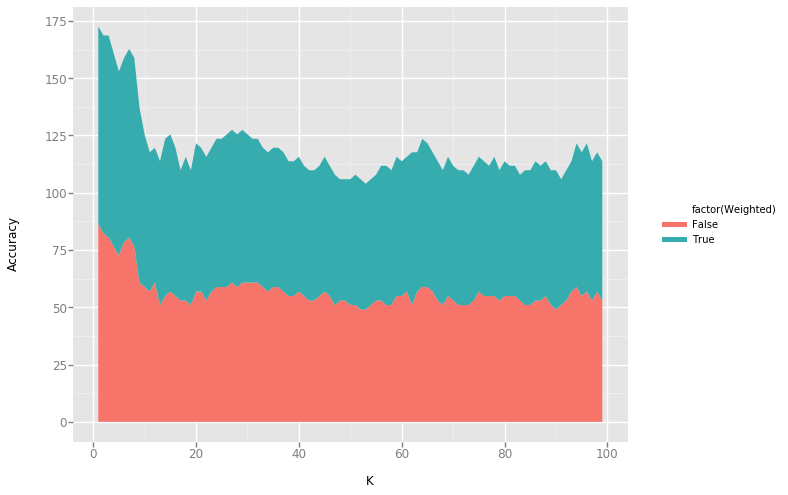

<ggplot: (8738354038434)>

In [16]:
ggplot(aes(x='K', y='Accuracy', fill='factor(Weighted)'), data=euc_K_on_accuracy_df) + \
    geom_area()

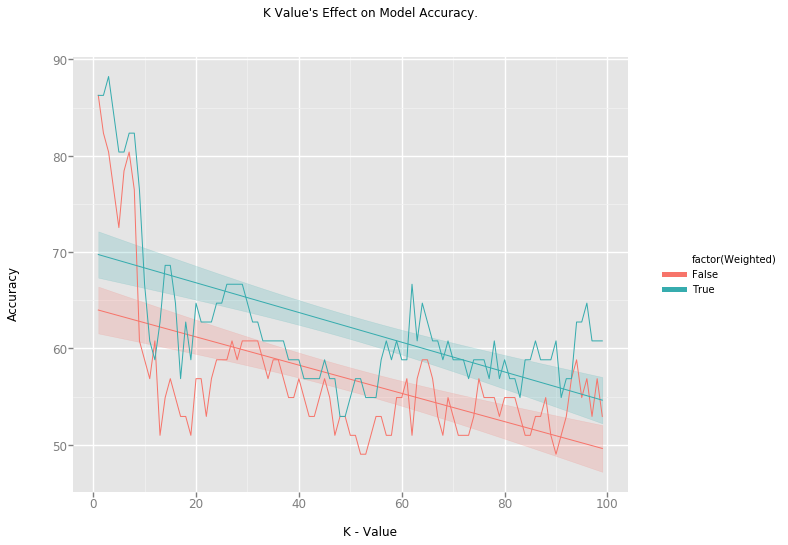

<ggplot: (-9223363298507345397)>

In [17]:
ggplot(aes(x='K', y='Accuracy', color='factor(Weighted)'), data=euc_K_on_accuracy_df) +\
    geom_line() + \
    stat_smooth(method = 'lm') +\
    xlab("K - Value") + \
    ylab("Accuracy") + \
    ggtitle("K Value's Effect on Model Accuracy.")

In [18]:
# ggplot(aes(x='factor(K)', weight='Accuracy', fill='factor(Weighted)'), data=K_on_accuracy_df) + \
#     geom_bar() + \
#     xlab("K - Value") + \
#     ylab("Accuracy") + \
#     ggtitle("K Value's ")
    

## Exercise
- Modify the code to explore further values of increasing k and plot the results in a bar chart. Explore how this changes from small values of k to larger values of k. 
- Compare the role of different similarity metrics on kNN performance. Again you may want to plot these on the bar chart using increasing k values. Can you explain your findings? 
- Setup a similar experiment using the mnist dataset from week 3. You will need to change the class index accordingly to load the dataset. Remember to use a small sample from the mnist (e.g. 500) as the original train set has 10,000 instances and may take a long time.

In [19]:
print("Setup the kNN instances ...")
man_knn_list = []

man_time_list = []
# iterate over different voting strategies
for weighted in is_weighted:
    man_knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for k in ks:
        #create the different instances of the kNN class
        
        knn = kNN(X_train, Y_train, k, manhattan, weighted)
        
        man_knn_list_element.append(knn)
        
        pass
    
    man_compiled_row = {}
    
    man_knn_list.append(man_knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
man_knn_results = []
man_knn_result_element = []

for knn1 in man_knn_list:
    man_knn_result_element = []

    for knn2 in knn1:
        knn2.test(X_test, Y_test)
             
        man_knn_result_element.append(accuracy(knn2.results))
        
        pass
    pass
    man_knn_results.append(man_knn_result_element)
    pass


Setup the kNN instances ...


In [20]:
man_compiled_results = []
for weight_index in range(0, len(man_knn_results)):
    for accuracy_index in range(0, len(man_knn_results[weight_index])):
        man_compiled_row = {}
        man_compiled_row['K'] = ks[accuracy_index]
        if weight_index:
            man_compiled_row['Weighted'] = True
        else:
            man_compiled_row['Weighted'] = False
        man_compiled_row['Accuracy'] = man_knn_results[weight_index][accuracy_index]
        man_compiled_results.append(man_compiled_row)

man_K_on_accuracy_df = pd.DataFrame(man_compiled_results)
man_K_on_accuracy_df

,Accuracy,K,Weighted
0,88.235294,1,False
1,78.431373,2,False
2,76.470588,3,False
3,76.470588,4,False
4,76.470588,5,False
5,78.431373,6,False
6,74.509804,7,False
7,70.588235,8,False
8,60.784314,9,False
9,60.784314,10,False


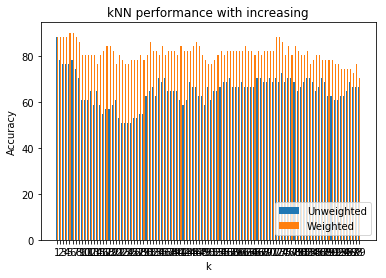

In [21]:
N = len(ks) # this is the number of results we want to plot pn the x-axis
ind = np.arange(N) 

performance1 = man_knn_results[0]
performance2 = man_knn_results[1]

width = 0.35 # width of the bar      
plt.bar(ind, performance1, width, label='Unweighted')
plt.bar(ind + width, performance2, width, label='Weighted')

plt.ylabel('Accuracy')
plt.xlabel('k')
plt.title('kNN performance with increasing')

plt.xticks(ind + width / 2, ks)
plt.legend(loc='lower right')
plt.show()

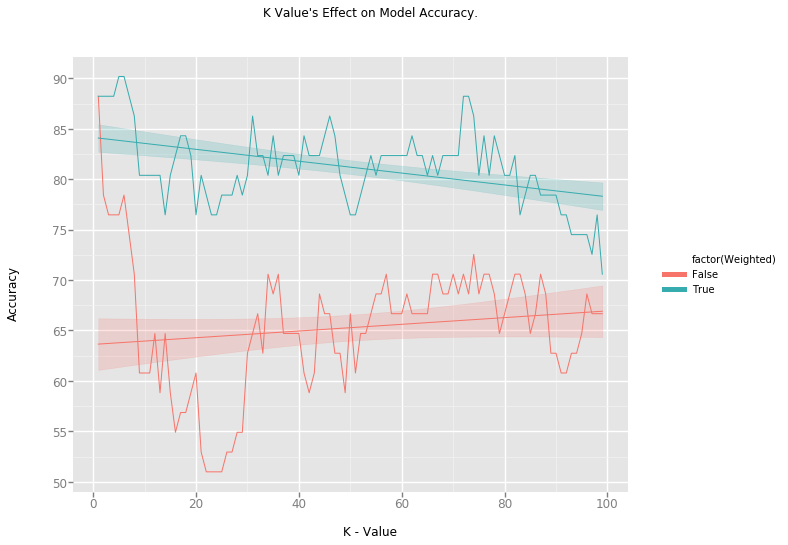

<ggplot: (-9223363298507438311)>

In [22]:
ggplot(aes(x='K', y='Accuracy', color='factor(Weighted)'), data=man_K_on_accuracy_df) +\
    geom_line() + \
    stat_smooth(method = 'lm') +\
    xlab("K - Value") + \
    ylab("Accuracy") + \
    ggtitle("K Value's Effect on Model Accuracy.")

In [23]:
print("Setup the kNN instances ...")
dot_knn_list = []

dot_time_list = []
# iterate over different voting strategies
for weighted in is_weighted:
    dot_knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for k in ks:
        #create the different instances of the kNN class
        
        knn = kNN(X_train, Y_train, k, dot_product, weighted)
        
        dot_knn_list_element.append(knn)
        
        pass
    
    dot_compiled_row = {}
    
    dot_knn_list.append(dot_knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
dot_knn_results = []
dot_knn_result_element = []

for knn1 in man_knn_list:
    dot_knn_result_element = []

    for knn2 in knn1:
        knn2.test(X_test, Y_test)
             
        dot_knn_result_element.append(accuracy(knn2.results))
        
        pass
    pass
    dot_knn_results.append(dot_knn_result_element)
    pass


Setup the kNN instances ...


In [24]:
dot_compiled_results = []
for weight_index in range(0, len(dot_knn_results)):
    for accuracy_index in range(0, len(dot_knn_results[weight_index])):
        dot_compiled_row = {}
        dot_compiled_row['K'] = ks[accuracy_index]
        if weight_index:
            dot_compiled_row['Weighted'] = True
        else:
            dot_compiled_row['Weighted'] = False
        dot_compiled_row['Accuracy'] = dot_knn_results[weight_index][accuracy_index]
        dot_compiled_results.append(dot_compiled_row)

dot_K_on_accuracy_df = pd.DataFrame(dot_compiled_results)
dot_K_on_accuracy_df

,Accuracy,K,Weighted
0,88.235294,1,False
1,78.431373,2,False
2,76.470588,3,False
3,76.470588,4,False
4,76.470588,5,False
5,78.431373,6,False
6,74.509804,7,False
7,70.588235,8,False
8,60.784314,9,False
9,60.784314,10,False


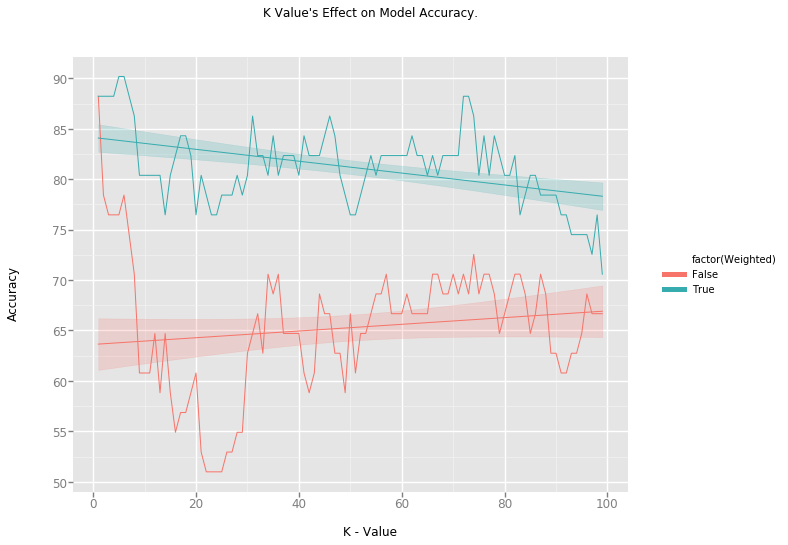

<ggplot: (-9223363298508860321)>

In [25]:
ggplot(aes(x='K', y='Accuracy', color='factor(Weighted)'), data=dot_K_on_accuracy_df) +\
    geom_line() + \
    stat_smooth(method = 'lm') +\
    xlab("K - Value") + \
    ylab("Accuracy") + \
    ggtitle("K Value's Effect on Model Accuracy.")